# IMPORT LIBRARIES

In [1]:
from PIL import Image
from random import random, randint, shuffle
from math import sqrt
from kNN import kNN
from sklearn.metrics import confusion_matrix
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# LOAD AND LABEL IMAGE FILES

In [16]:
path_Cynthia = os.path.join('C:/Users/Blssm/Desktop/ML_Project/sorted_faces/Cynthia','*g')
files_Cynthia = glob.glob(path_Cynthia)

path_Jerry = os.path.join('C:/Users/Blssm/Desktop/ML_Project/sorted_faces/Jerry','*g')
files_Jerry = glob.glob(path_Jerry)

path_Marine = os.path.join('C:/Users/Blssm/Desktop/ML_Project/sorted_faces/Marine','*g')
files_Marine = glob.glob(path_Marine)

# Define the total number of loaded files for each class
n_Cynthia = len(files_Cynthia)
n_Jerry = len(files_Jerry)
n_Marine = len(files_Marine)
n_data = n_Cynthia + n_Jerry + n_Marine

# Build the labeled data list
data = []

for f in files_Cynthia:
    img = Image.open(f)
    img = img.resize((500,500))
    img = img.convert('L')
    data.append([img,'Cynthia'])

for f in files_Jerry:
    img = Image.open(f)
    img = img.resize((500,500))
    img = img.convert('L')
    data.append([img,'Jerry'])

for f in files_Marine:
    img = Image.open(f)
    img = img.resize((500,500))
    img = img.convert('L')
    data.append([img,'Marine'])
    
shuffle(data,random)

In [17]:
print('Exemple of data : ', data[0])

Exemple of data :  [<PIL.Image.Image image mode=L size=500x500 at 0x292226B6188>, 'Jerry']


# DISPLAY FEW EXAMPLES OF IMAGES

# SEPARATE TRAINING AND TEST SETS FROM DATA

In [19]:
p_train = 0.7 # percentage of data used for the training task
n_train = int(p_train * n_data)
n_test = n_data - n_train

train_images = []
train_labels = []

for d in data[:n_train]:
    train_images.append(d[0])
    train_labels.append(d[1])
     
test_images = []
test_labels = []
        
for d in data[n_train:]:
    test_images.append(d[0])
    test_labels.append(d[1])

In [20]:
print([test_labels.count('Cynthia'), test_labels.count('Jerry'), test_labels.count('Marine')])
print([train_labels.count('Cynthia'), train_labels.count('Jerry'), train_labels.count('Marine')])

[8, 9, 4]
[14, 14, 18]


# FROM IMAGES TO MATRIXES...

In [21]:
train_data = [np.array(img) for img in train_images]
test_data = [np.array(img) for img in test_images]

# TRAIN DATA PROCESSING : IMPCA METHOD

In [22]:
A_mean = sum(A for A in train_data) / n_train

Gt = sum((A-A_mean).T@(A-A_mean) for A in train_data) / n_train

eigval,eigvect = np.linalg.eig(Gt)
idx = eigval.argsort()[::-1]
eigval = eigval[idx]
eigvect = eigvect[:,idx]

k = 7 # number of principal components retained
PC = eigvect[:,0:k] 

temp1 = [A@PC for A in train_data]
temp2 = [A.T for A in temp1]
dim = temp2[0].shape
new_train_data = [np.reshape(A, dim[0]*dim[1]) for A in temp2]

In [23]:
new_train_data = np.array(new_train_data)
new_train_data.shape # (n_train , size_image * nb_PC)

(46, 3500)

# TEST DATA PROCESSING : IMPCA METHOD

In [24]:
temp1 = [A@PC for A in test_data]
temp2 = [A.T for A in temp1]
dim = temp2[0].shape
new_test_data = [np.reshape(A, dim[0]*dim[1]) for A in temp2]

In [25]:
new_test_data = np.array(new_test_data)
new_test_data.shape # (n_test , size_image * nb_PC)

(21, 3500)

# PREDICTION : KNN METHOD

In [26]:
def accuracy_for_any_k(k):
    # Run kNN algorithm
    predicted_labels = [''] * n_test

    for i in range(n_test):
        predicted_labels[i] = kNN(k, new_train_data, train_labels, new_test_data[i,:])

    # Calculate accuracy
    correct = 0

    for i in range(n_test):
        if predicted_labels[i] == test_labels[i]:
            correct += 1

    accuracy = correct/float(n_test)
    return(accuracy)

In [27]:
# Rule of thumb for initial guess
k_thumb = int(sqrt(n_train))
print('Rule of thumb k : ',k_thumb)
print('Rule of thumb accuracy : ',accuracy_for_any_k(k_thumb))

Rule of thumb k :  6
Rule of thumb accuracy :  0.8095238095238095


Local maximum accuracy k :  8
Local maximum accuracy :  0.8571428571428571


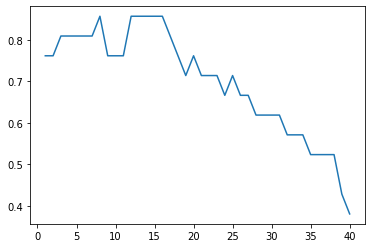

In [28]:
# Identify a k of local maximum accuracy
nb_neighbors = [k for k in range(1,41)] # upper limit should be above k_thumb AND below n_train 
accuracies = [accuracy_for_any_k(k) for k in nb_neighbors]

k_max = accuracies.index(max(accuracies)) + 1

print('Local maximum accuracy k : ',k_max)
print('Local maximum accuracy : ',max(accuracies))
plt.plot(nb_neighbors,accuracies)

# CONFUSION MATRIX

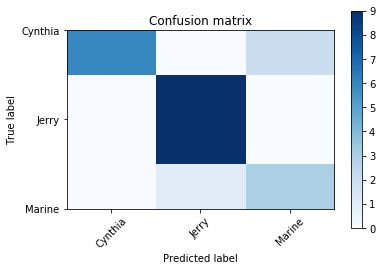

In [29]:
predicted_labels = [''] * n_test

for i in range(n_test):
    predicted_labels[i] = kNN(k_max, new_train_data, train_labels, new_test_data[i,:])

labels = ["Cynthia", "Jerry", "Marine"]
C = confusion_matrix(test_labels, predicted_labels, labels=labels)

plt.figure()

plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

plt.show()